Another candiate is wolf1130. It has HST data, white dwarf will be an FUV target

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.convolution import convolve, Box1DKernel

from scipy.interpolate import interp1d


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

HST files were not extracted? Have to do it myself...nope, there is a HLSP, phew.

In [3]:
path = '/media/david/2tb_ext_hd/hddata/carmenes_binary/wolf1130/hst/hlsp/'
data = fits.getdata('{}hlsp_lowlib_hst_stis_lhs482_g230lb-g430l-g750l_v1.0_spect.fits'.format(path), 1)

In [4]:
data.names

['Wavelength',
 'Uncorrected',
 'Error_uncorrect',
 'Scattered Light Corrected',
 'Error_scattered_light',
 'Scattered Light & Slit Offcenter Corrected',
 'Error_scattered_slit',
 'Scattered Light, Slit Offcenter, and Dust Corrected',
 'Error_scattered_slit_dust']

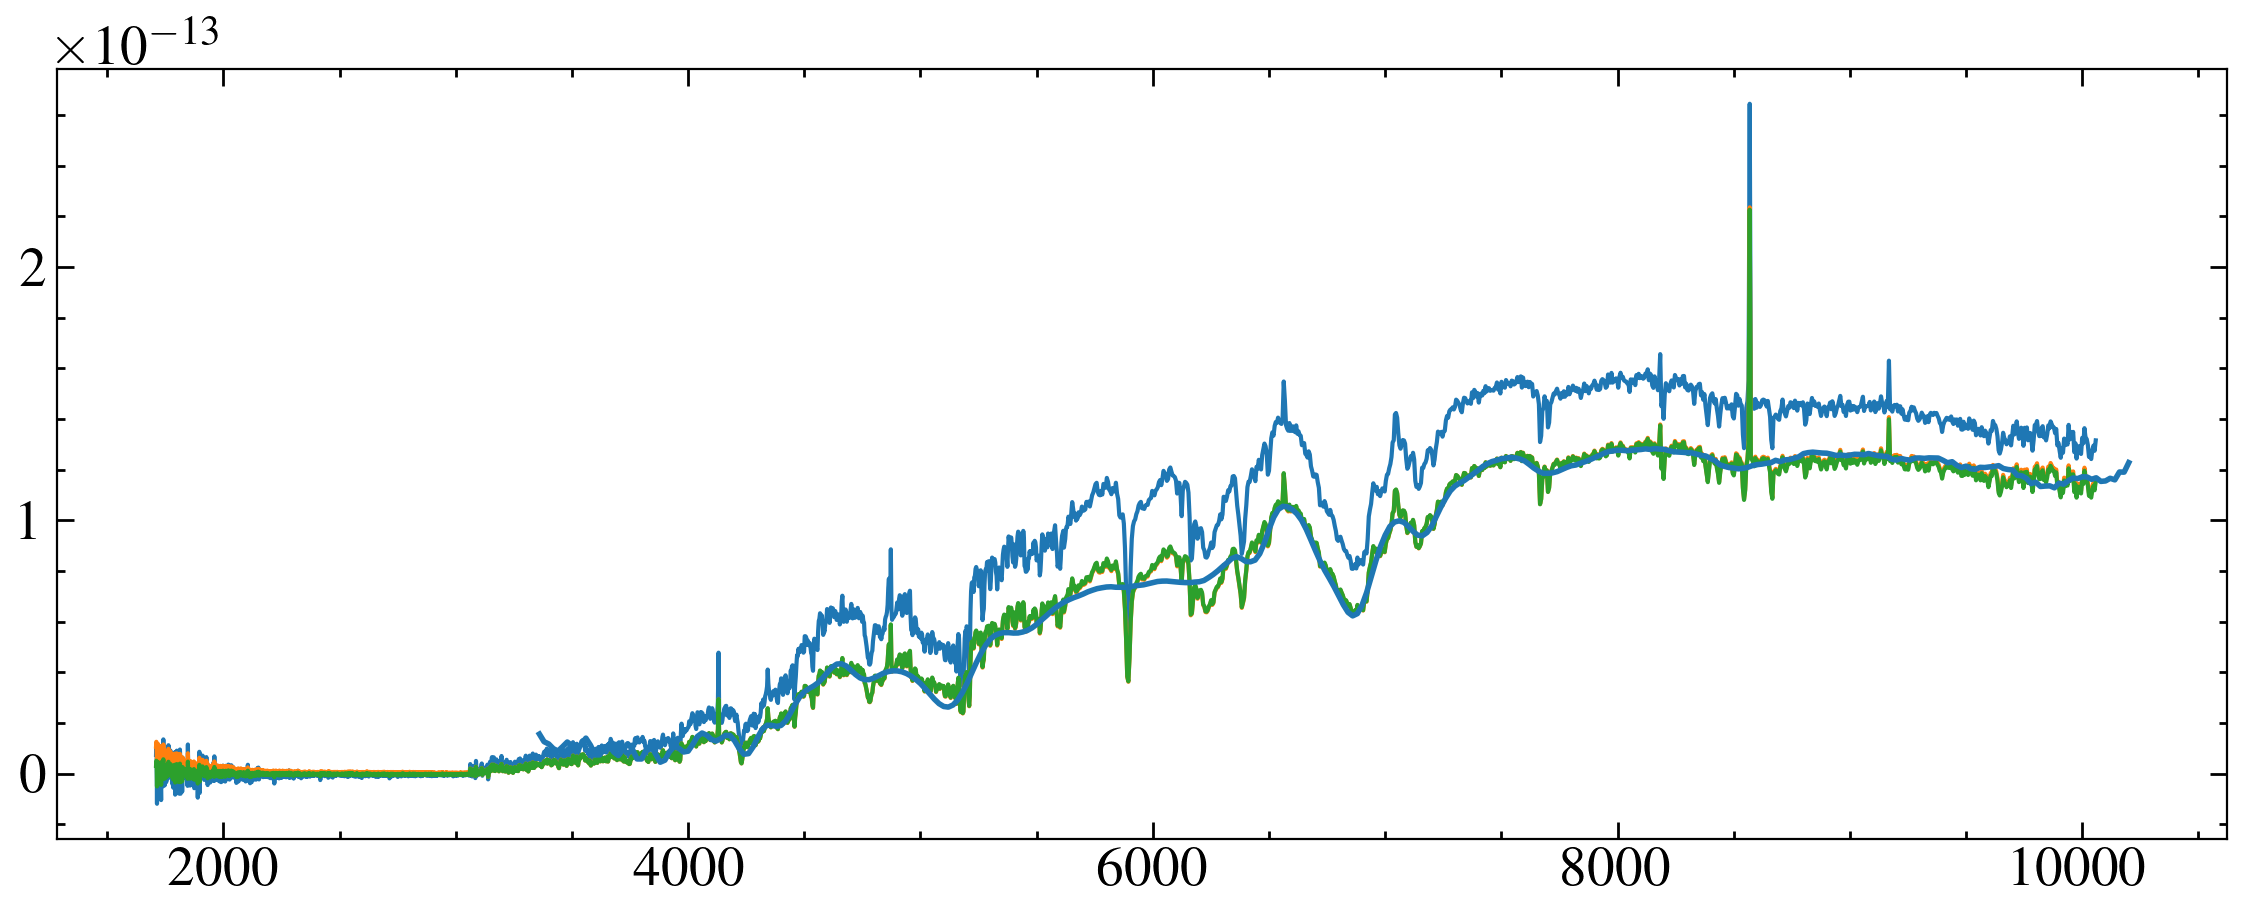

In [5]:
fig, ax = plt.subplots()
ax.plot(data['Wavelength'], data['Scattered Light, Slit Offcenter, and Dust Corrected'])
ax.plot(data['Wavelength'], data['Uncorrected'])
ax.plot(data['Wavelength'], data['Scattered Light & Slit Offcenter Corrected'])


gaia = Table.read('data/wolf1120_gaia_spectrum.vot')
mask = gaia['type'] == 'XP'
ax.plot(gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA), 
           label = 'Gaia XP spectrum', c='C0', lw=2)

gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
sw, sf, se = data['Wavelength'], data['Scattered Light & Slit Offcenter Corrected'], data['Error_scattered_slit']
# sw, sf, se = data['Wavelength'], data['Uncorrected'], data['Error_uncorrect']

So it's the scattered light and slit off center corrected one we want to see what will be observed.

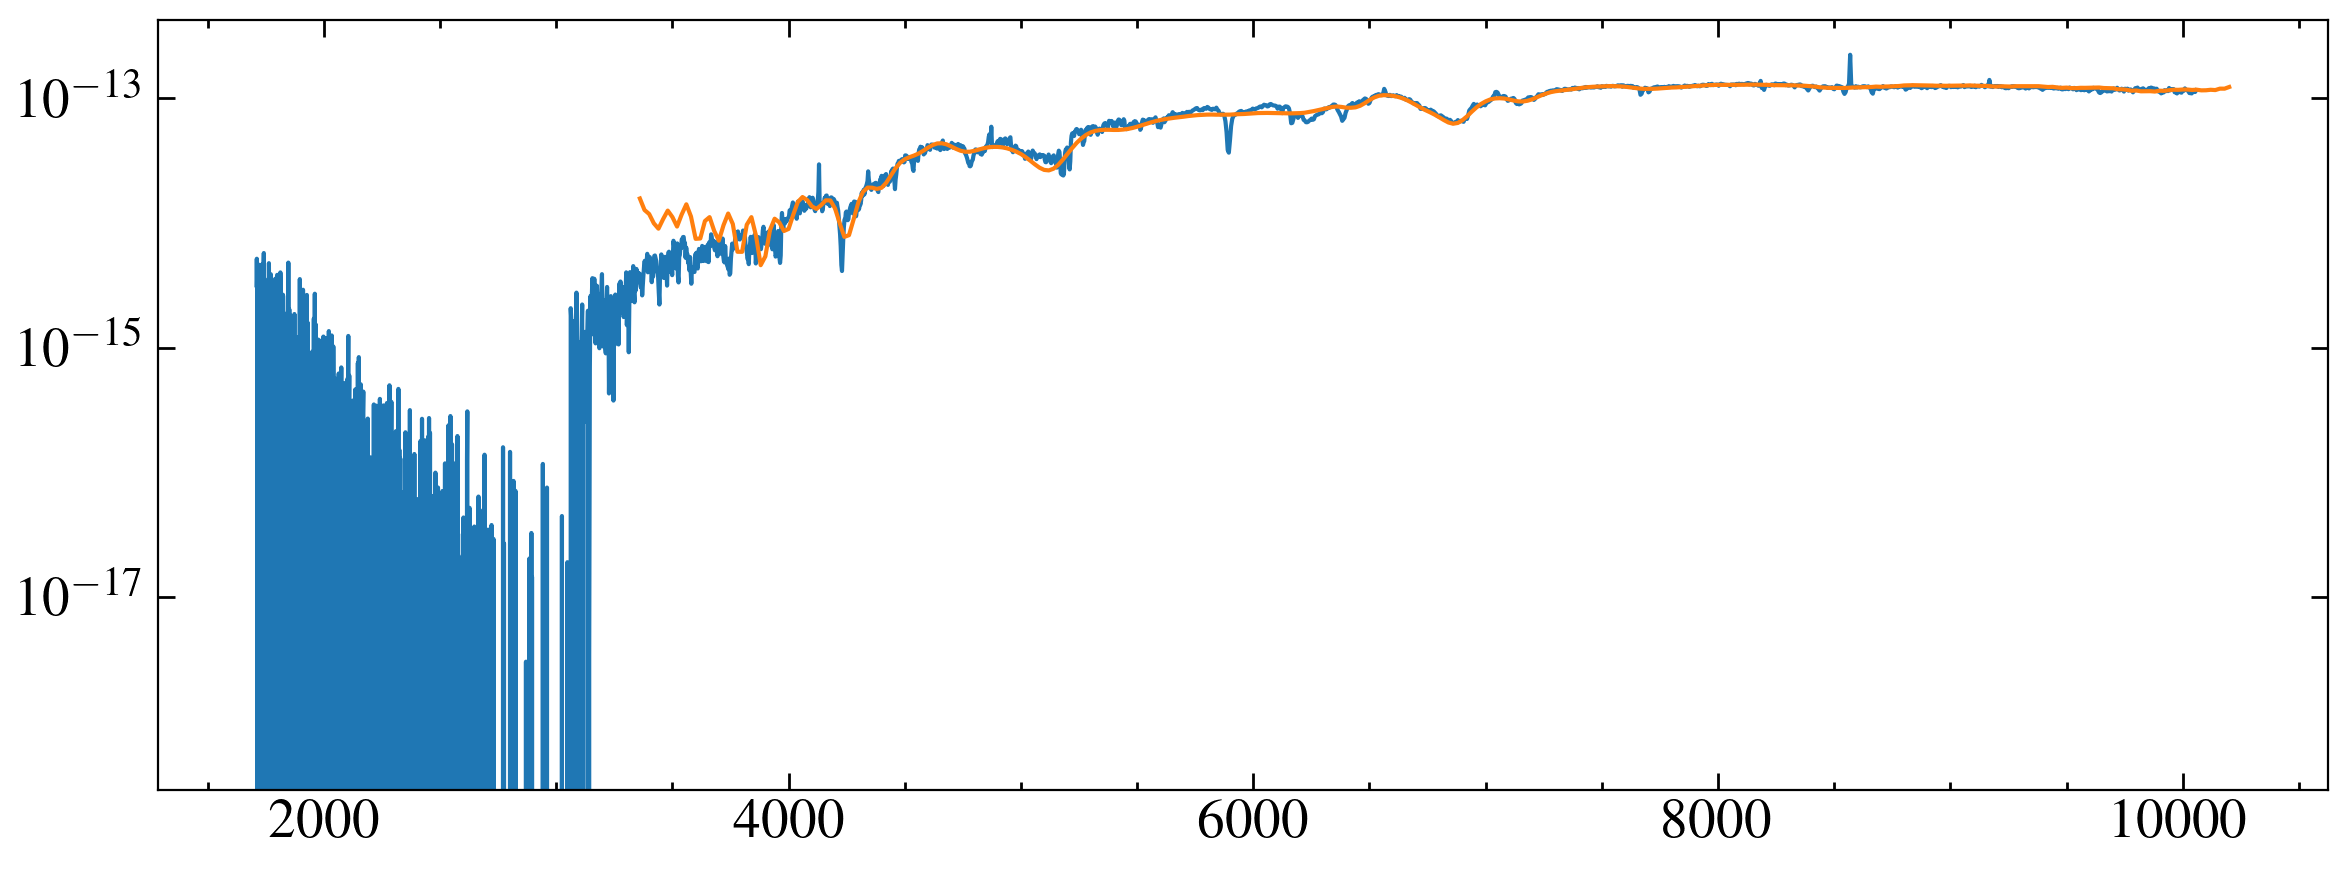

In [6]:
fig, ax = plt.subplots()
ax.plot(sw, sf)
ax.plot(gw, gf)

ax.set_yscale('log')
# ax.set_xscale('log')

(-1e-15, 1e-15)

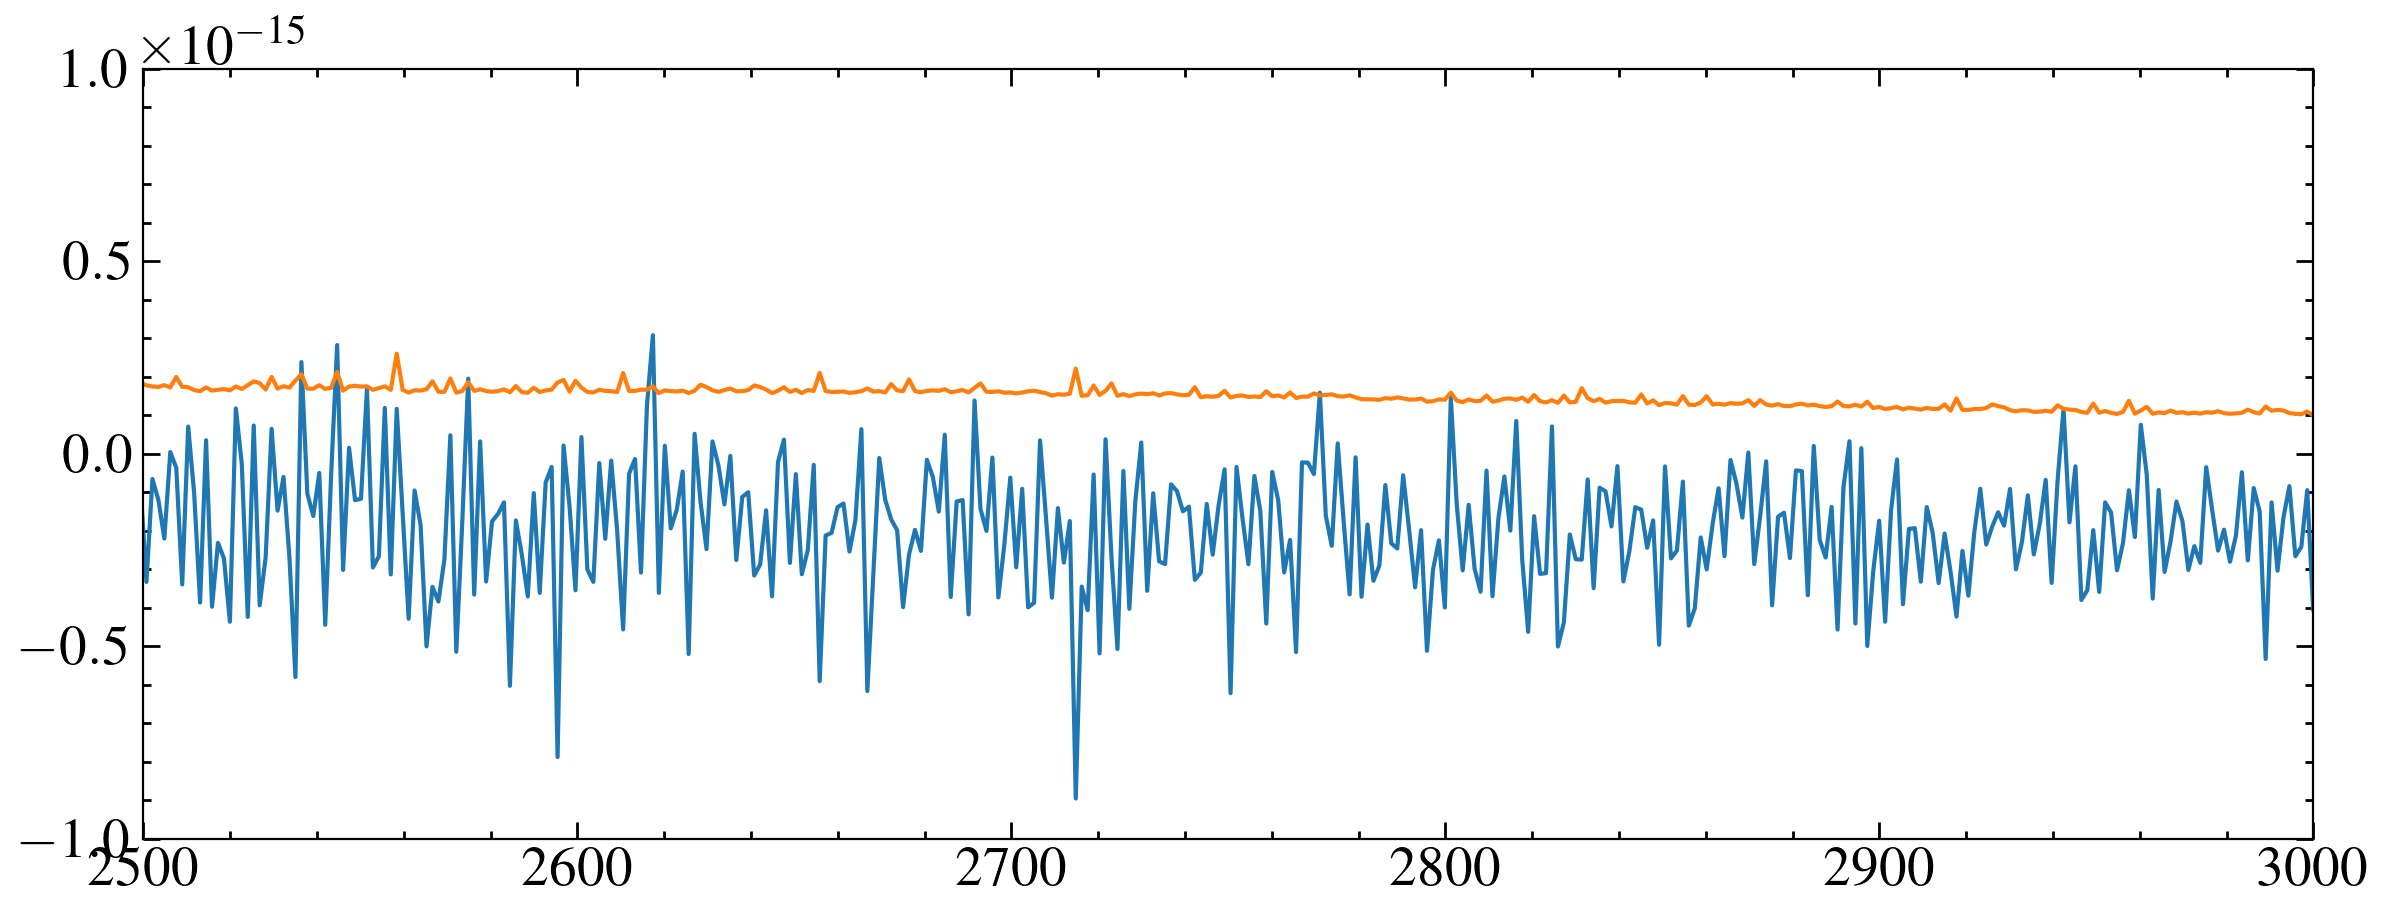

In [7]:
fig, ax = plt.subplots()
ax.plot(sw, sf)
ax.plot(sw, se)
ax.plot(gw, gf)


# ax.set_yscale('log')
ax.set_xlim(2500, 3000)
ax.set_ylim(-1e-15, 1e-15)


What's up with the 230L data? Mg ii is missing compared to Mace+

In [8]:
import stistools

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [9]:
path = '/media/david/2tb_ext_hd/hddata/carmenes_binary/wolf1130/hst/data/'
os.environ['oref'] = path

In [10]:
# roots = ['o8ru2h010', 'o8ru2h020']
# ys = [58, 58]
# for i, root in  enumerate(roots):
#     flt = '{}{}_flt.fits'.format(path, root)
#     # SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
#     # grating = fits.getheader(flt,0)['OPT_ELEM']
#     # cenwave = fits.getheader(flt,0)['CENWAVE']
#     # tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
#     rootname = fits.getheader(flt)['ROOTNAME'] 
#     outname = 'data/reextractions/{}_new_x1d.fits'.format(rootname)
#     # a2center = get_a2center(410,181, tracegrid)
#     # print(a2center)
#     stistools.x1d.x1d(flt, output = outname, trailer='data/reextractions/{}_new.trl'.format(rootname), a2center=ys[i], maxsrch=0)
#     # stistools.calstis.calstis(flt, outroot=outname)

data/reextractions/o8ru2h020_new_x1d.fits
G230LB
600.0
[58.]
data/reextractions/o8ru2h010_new_x1d.fits
G230LB
600.0
[58.]


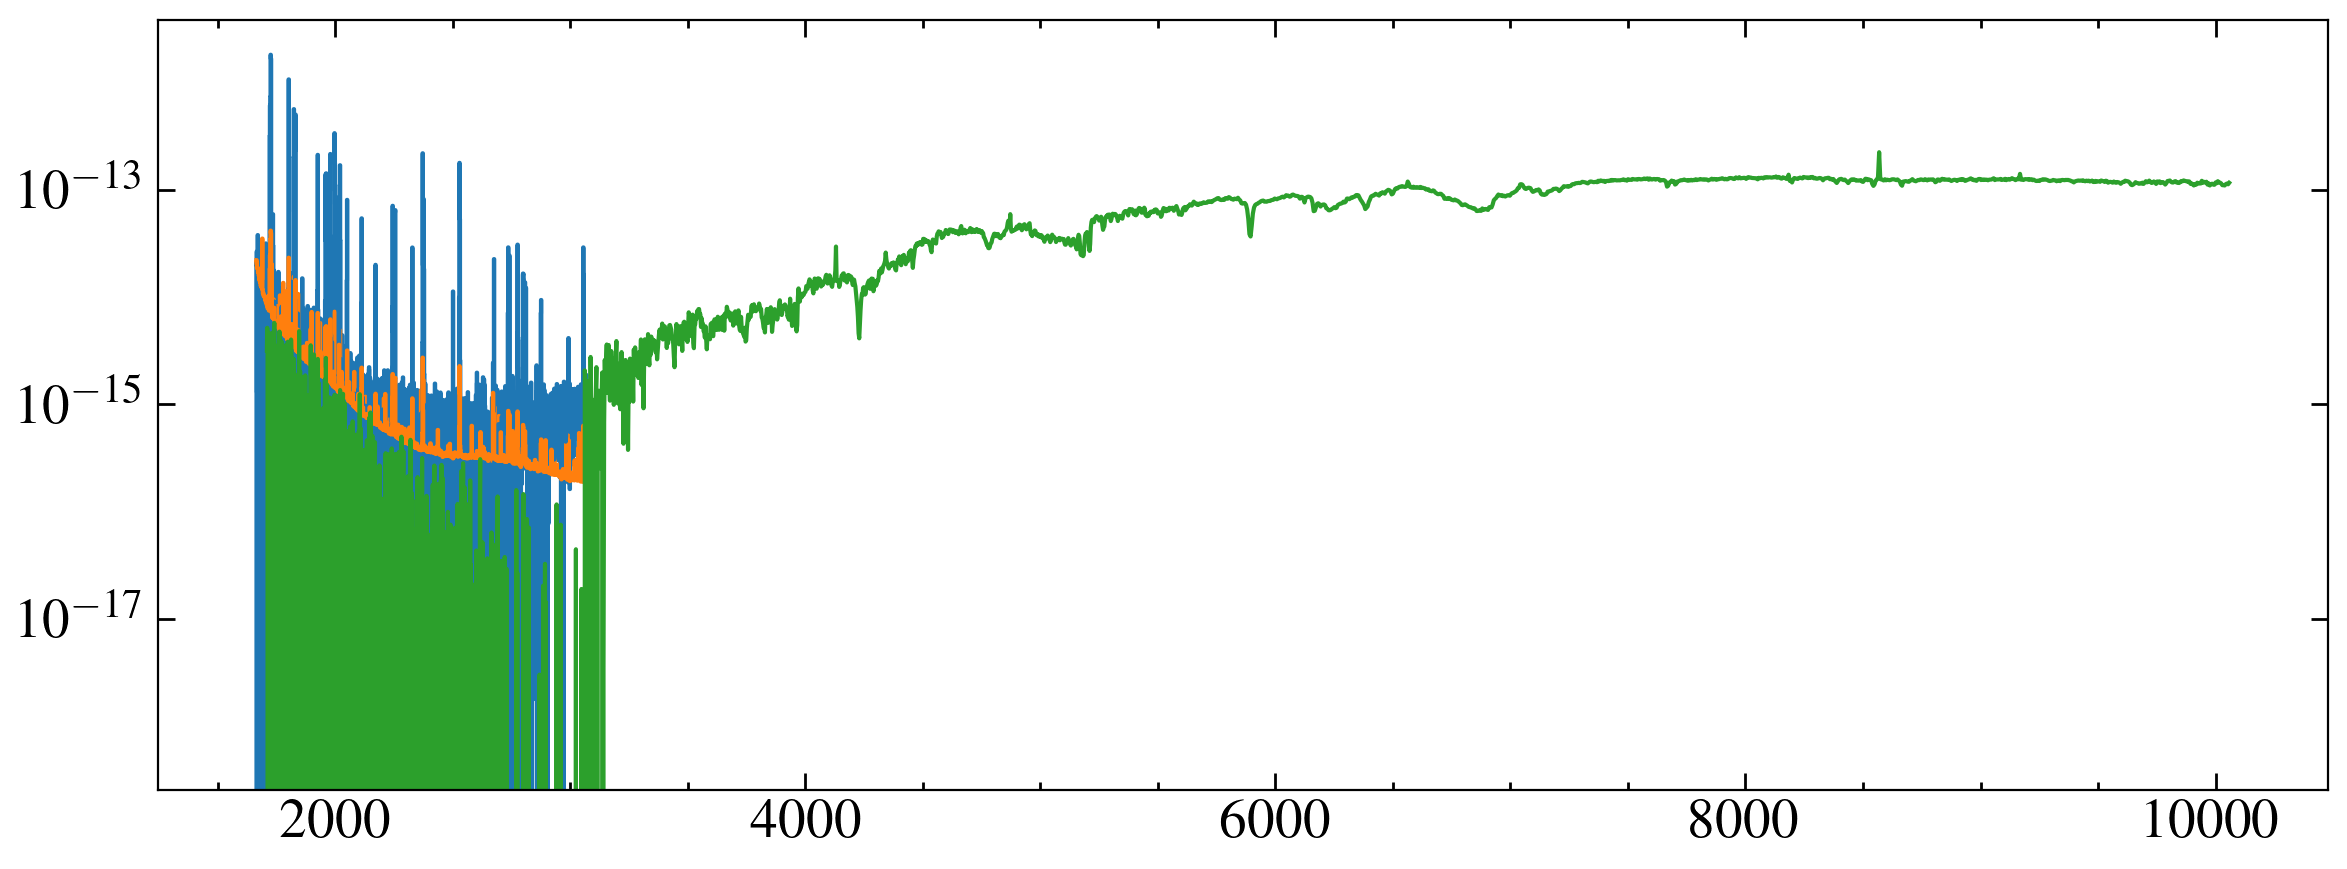

In [11]:
new_x1ds = glob.glob('data/reextractions/*x1d.fits')

for x in new_x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    print(fits.getheader(x, 0)['TEXPTIME'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.yscale('log')
    # plt.show()

    
plt.plot(sw, sf, c='C2')

In [12]:
def coadd_flux(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    if len(f_array) > 1:
        weights = 1 / (e_array**2)
        flux = np.average(f_array, axis =0, weights = weights)
        var = 1 / np.sum(weights, axis=0)
        rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
        if scale_correct:
            error = (var * rcs)**0.5
        else:
            error = var**0.5
    else:
        flux, error = f_array[0,:], e_array[0,:]
    return flux,error

In [13]:
f_nuv = []
e_nuv = []


n=0
for x in new_x1ds:
    data = fits.getdata(x, 1)[0]
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'G230LB':
        # mask = (w > 1800) & (w <3130)
        # w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_nuv = w
            f_nuv.append(f)
            e_nuv.append(e)
        else:
            f_nuv.append(interp1d(w, f, fill_value='extrapolate')(w_nuv))
            e_nuv.append(interp1d(w, e, fill_value='extrapolate')(w_nuv))            
        n +=1
        
f_nuv, e_nuv = coadd_flux(np.array(f_nuv), np.array(e_nuv), scale_correct=True)


In [28]:
newspec = Table([w_nuv, f_nuv, e_nuv], names=['WAVELENGTH', 'FLUX', 'ERROR'])
newspec.write('data/wolf1130_nuv.ecsv', format='ascii.ecsv', overwrite=True)

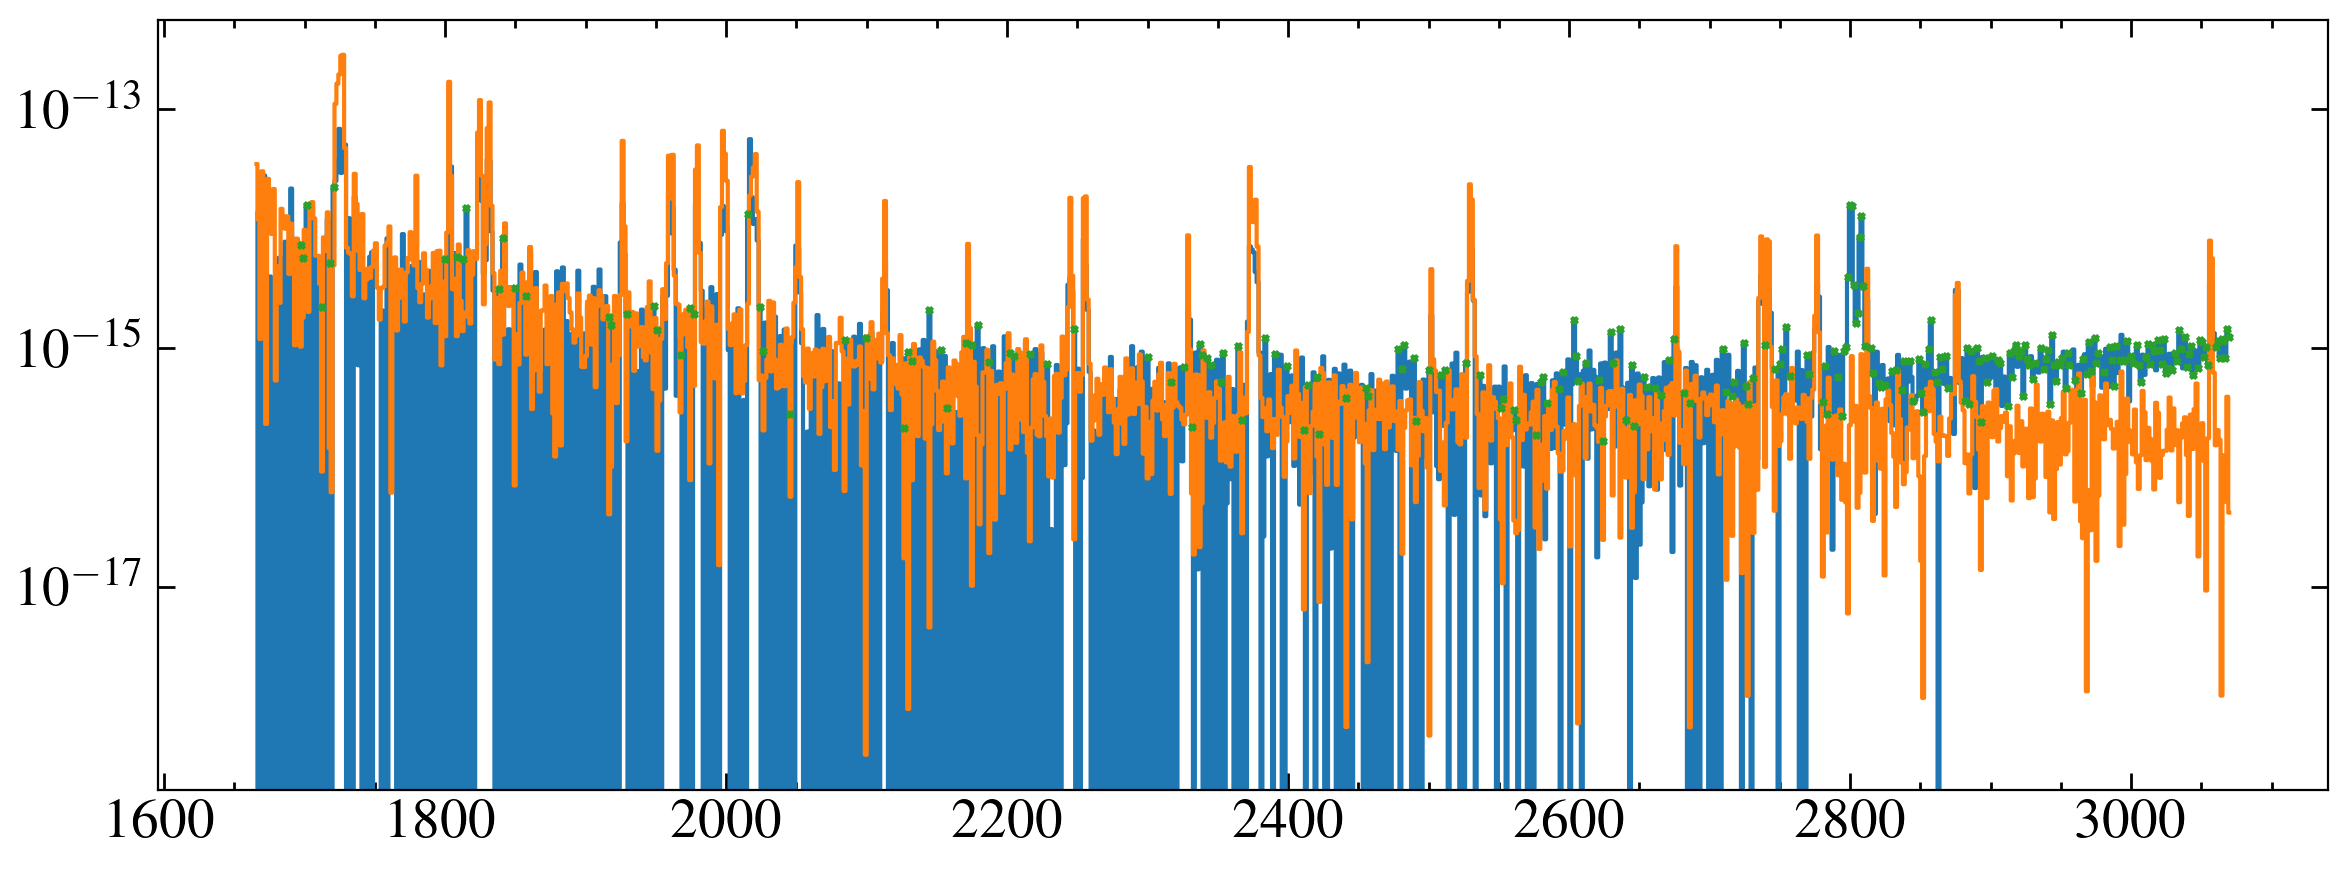

In [14]:
plt.step(w_nuv, f_nuv, where='mid')
plt.step(w_nuv, e_nuv, where='mid')

plt.yscale('log')

mask = (f_nuv/e_nuv) > 3
# plt.step(w_nuv[mask], f_nuv[mask], where='mid')
plt.scatter(w_nuv[mask], f_nuv[mask], s=5, marker='x', c='C2', zorder=10)


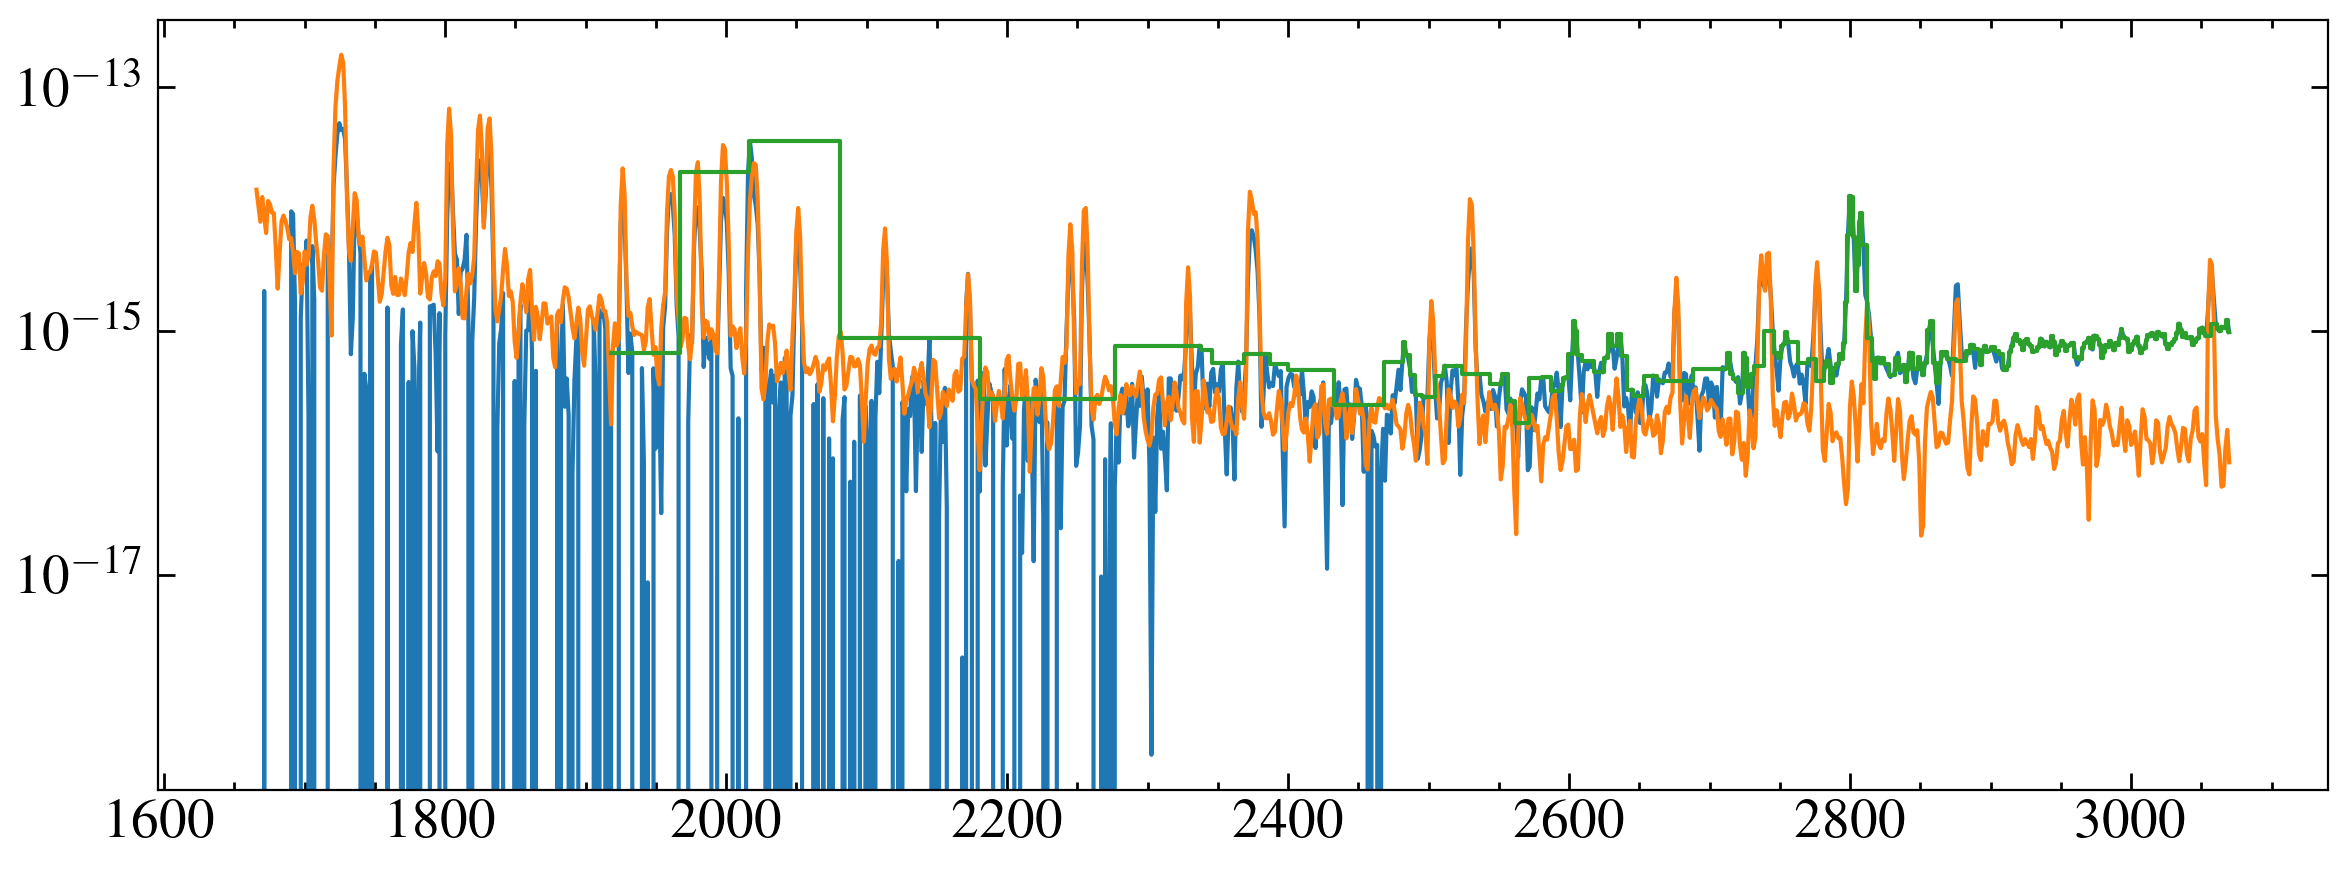

In [15]:
fi = convolve(f_nuv,  Box1DKernel(2))
ei = convolve(e_nuv,  Box1DKernel(2))/2**0.5

plt.plot(w_nuv, fi)
plt.plot(w_nuv, ei)

mask = (fi/ei) > 3
plt.step(w_nuv[mask], fi[mask], where='mid')
# plt.scatter(w_nuv[mask], fi[mask], s=5, marker='x', c='C2', zorder=10)
plt.yscale('log')

What do white dwarf models look like compared to that spectrum? Turn it into an ummer limit before 2600?

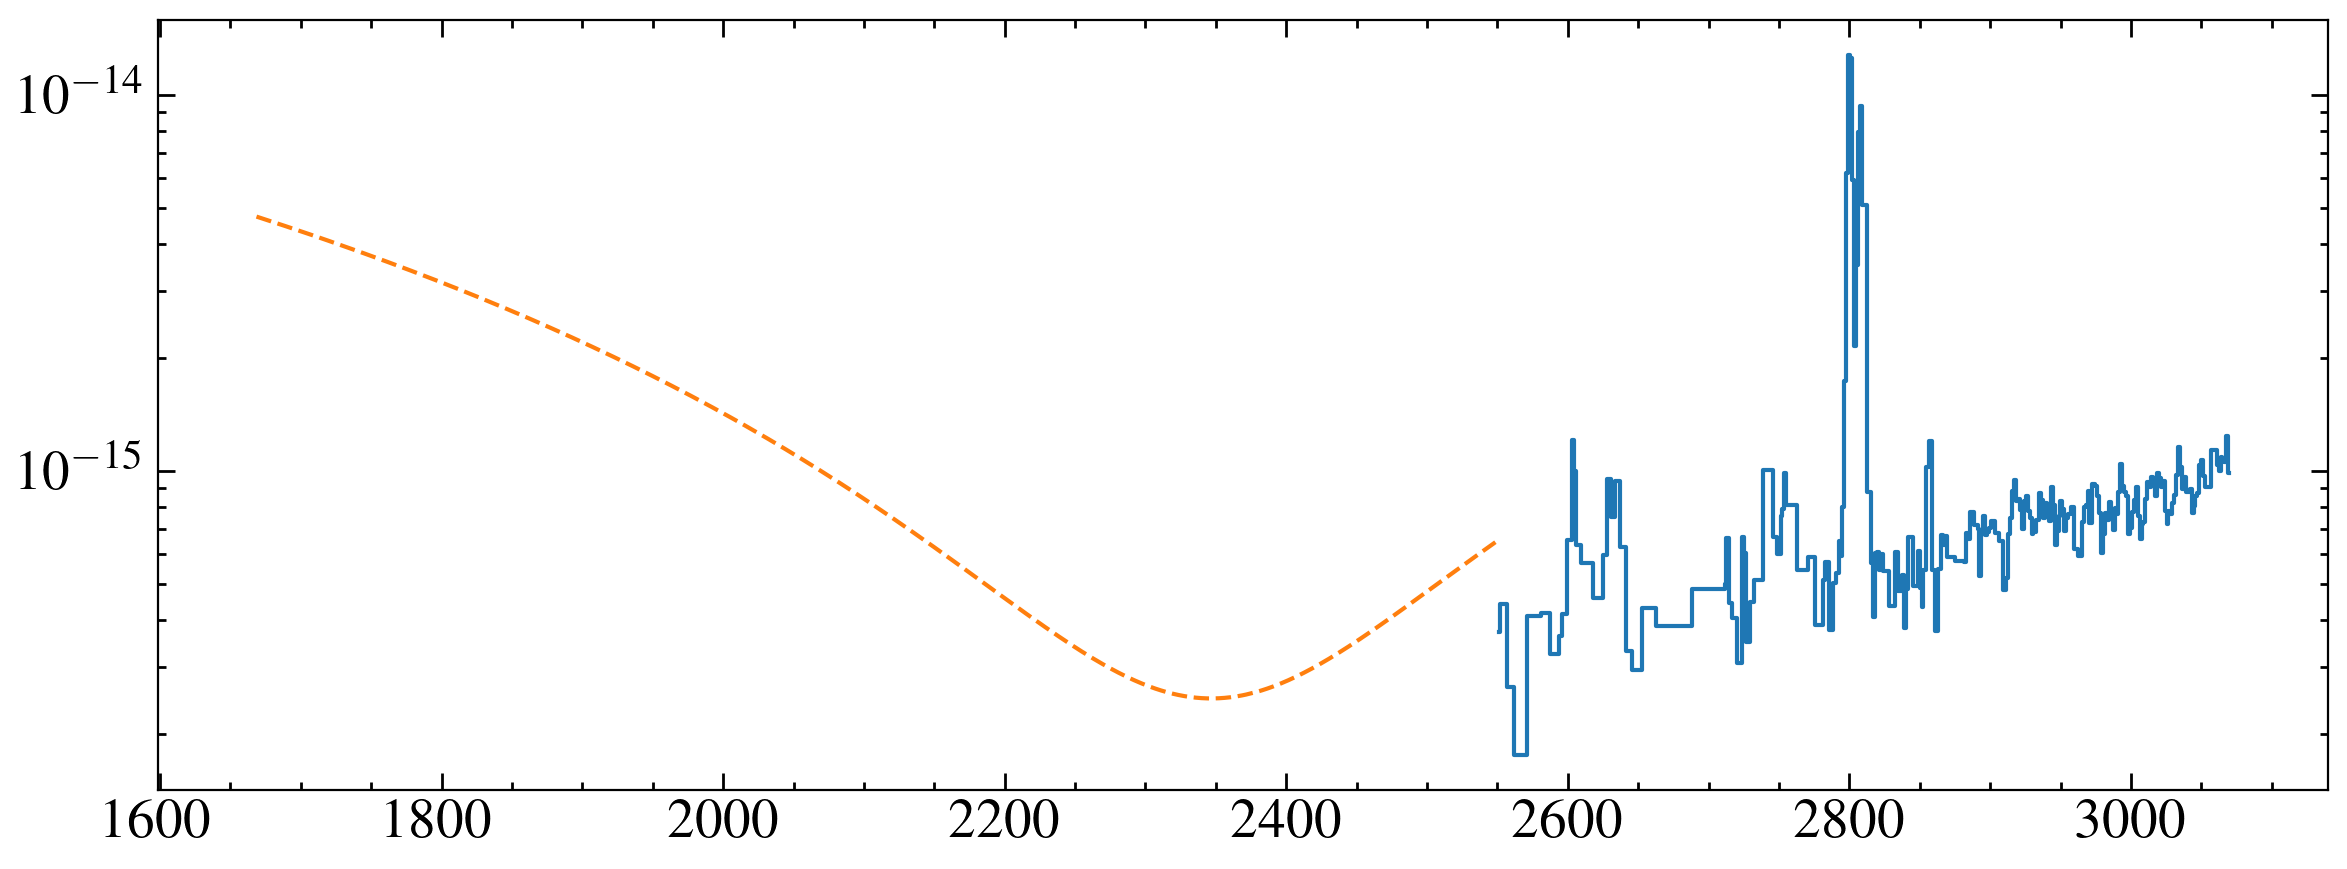

In [16]:
truemask = ((fi/ei) > 3) & (w_nuv > 2550)
upmask = (w_nuv <= 2600) & (ei < 1e-14)

wn, fn, en = w_nuv[truemask], fi[truemask], ei[truemask]
plt.step(wn, fn, where='mid')

wup, fup = w_nuv[upmask], ei[upmask]
fitter = fitting.LinearLSQFitter()
mod = models.Polynomial1D(2)
modfit = fitter(mod, wup, fup)
#fit polynomial to the error?

upmask2 = wup < 2550

wup = wup[upmask2]
# fup = convolve(fup,  Box1DKernel(50))
# plt.plot(wup, fup, ls='--')

fup = modfit(wup)

plt.plot(wup, fup, ls='--')

plt.yscale('log')

# mods = 

In [17]:
modpath = '/media/david/2tb_ext_hd/hddata/carmenes_binary/'
mods = glob.glob('{}models_1628872352/koester2/*.dat.txt'.format(modpath))
mods

['/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05250_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05500_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da05750_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06250_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06500_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da06750_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da07000_800.dk.dat.txt',
 '/media/david/2tb_ext_hd/hddata/carmenes_binary/models_1628872352/koester2/da07250_800.dk.

16.7


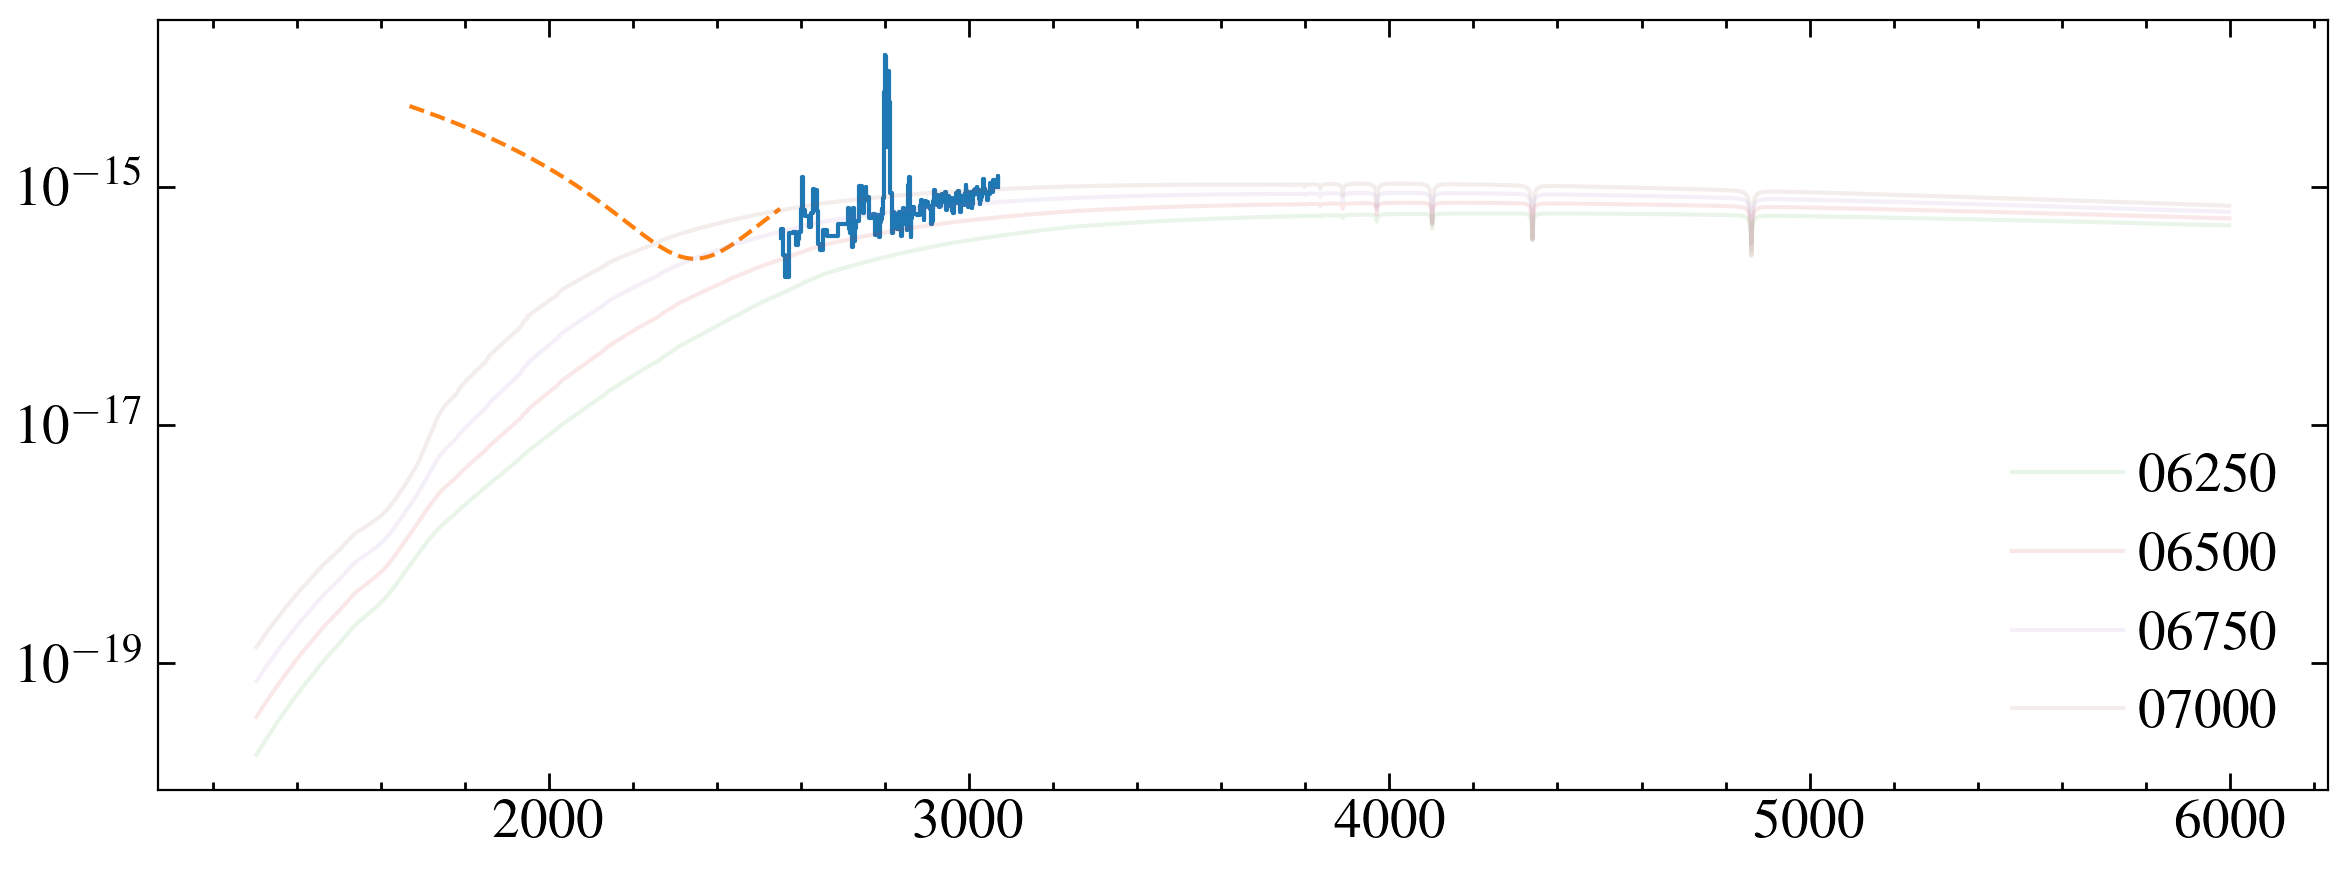

In [18]:
fig, ax = plt.subplots()

# pmask = (pw > 1300) & (pw < 6000)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 1000)


# ax.errorbar(phot_w, phot_f, yerr=phot_e, marker='o', ls='none')
# print(phot_f, phot_e)

dstar = 16.7 
print(dstar)
rwd = 0.005*u.Rsun
wd_scale = (rwd.to(u.m)/(dstar*u.pc).to(u.m))**2


# ax.plot(pwi, pfi)
ax.step(wn, fn, where='mid')
ax.plot(wup, fup, ls='--')

for model in mods[5:9]:
    tmod = os.path.split(model)[1][2:7]
    mw, mf = np.loadtxt(model, unpack=True)
    wdmask =  (mw > 1300) & (mw < 6000)
    mw, mf = mw[wdmask], mf[wdmask]*wd_scale
#     mfi = interp1d(mw, mf, fill_value='extrapolate')(pwi)
#     mfi = mfi+pfi
#     mfi = interp1d(mw, mf, fill_value='extrapolate')(dmw1)
#     mfi = mfi+(dmf1*scale)
    ax.plot(mw, mf, alpha=0.1, label=tmod)
    
    
    # ax.plot(dmw1, mfi, alpha=0.2, label = tmod)
    # ax.plot(mw[wdmask], mf[wdmask]*wd_scale, alpha=0.2)
# ax.plot(dmw1, dmf1*scale)
ax.legend()

ax.set_yscale('log')


Is it detectable in COS? make model with stis data+ 6750K wd model

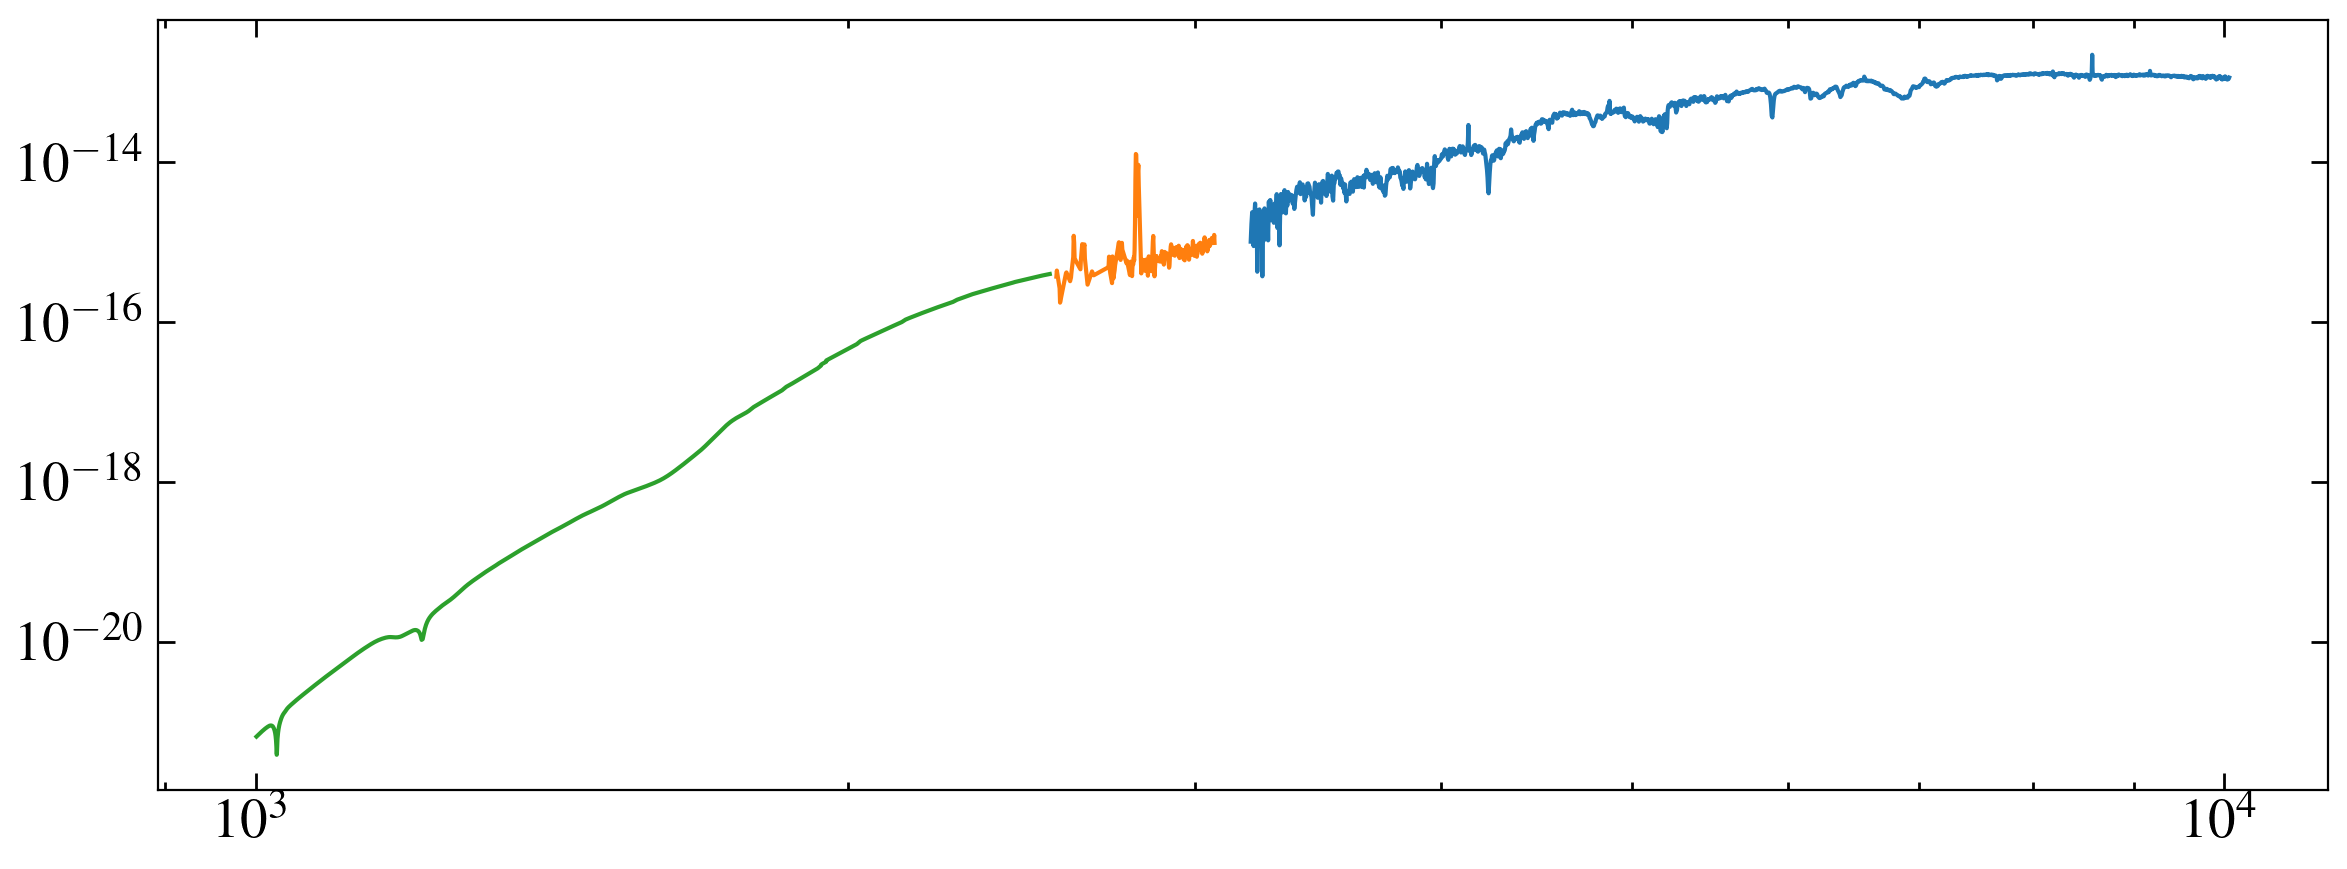

In [19]:
smask = sw > 3200
plt.plot(sw[smask], sf[smask])
plt.plot(wn, fn)
plt.yscale('log')
plt.xscale('log')

wdw, wdf = np.loadtxt(mods[7], unpack=True)
wdmask =  (wdw > 1000) & (wdw < wn[0]-10)
wdw, wdf = wdw[wdmask], wdf[wdmask]*wd_scale
plt.plot(wdw, wdf)

modw = np.hstack((wdw, wn, sw[smask]))
modf = np.hstack((wdf, fn, sf[smask]))

mod = Table([modw, modf], names=['#WAVELENGTH', 'FLUX'])
mod.write('wolf1130_model.dat', format='ascii.basic', overwrite=True)

Whelp https://etc.stsci.edu/etc/results/COS.sp.1844899/ 

In [20]:
4513872839*u.s.to(u.yr)

143.03599890359214

In [21]:
# np.log10(((((0.44*u.Msun).to(u.kg))*const.G)/(((0.44*u.Rsun).to(u.m))**2)).to(u.cm/u.s**2).value)

GJ832 might be a decent proxy

In [22]:
prox = fits.getdata('/media/david/2tb_ext_hd/hddata/mega_muscles/muscles_hlsp/gj832/hlsp_muscles_multi_multi_gj832_broadband_v22_adapt-var-res-sed.fits', 1)
# data = fits.getdata('{}/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_var-res-sed.fits'.format(path))
dmw, dmf = prox['WAVELENGTH'], prox['FLUX']

0.08839274943323047
06500


(1800.0, 5500.0)

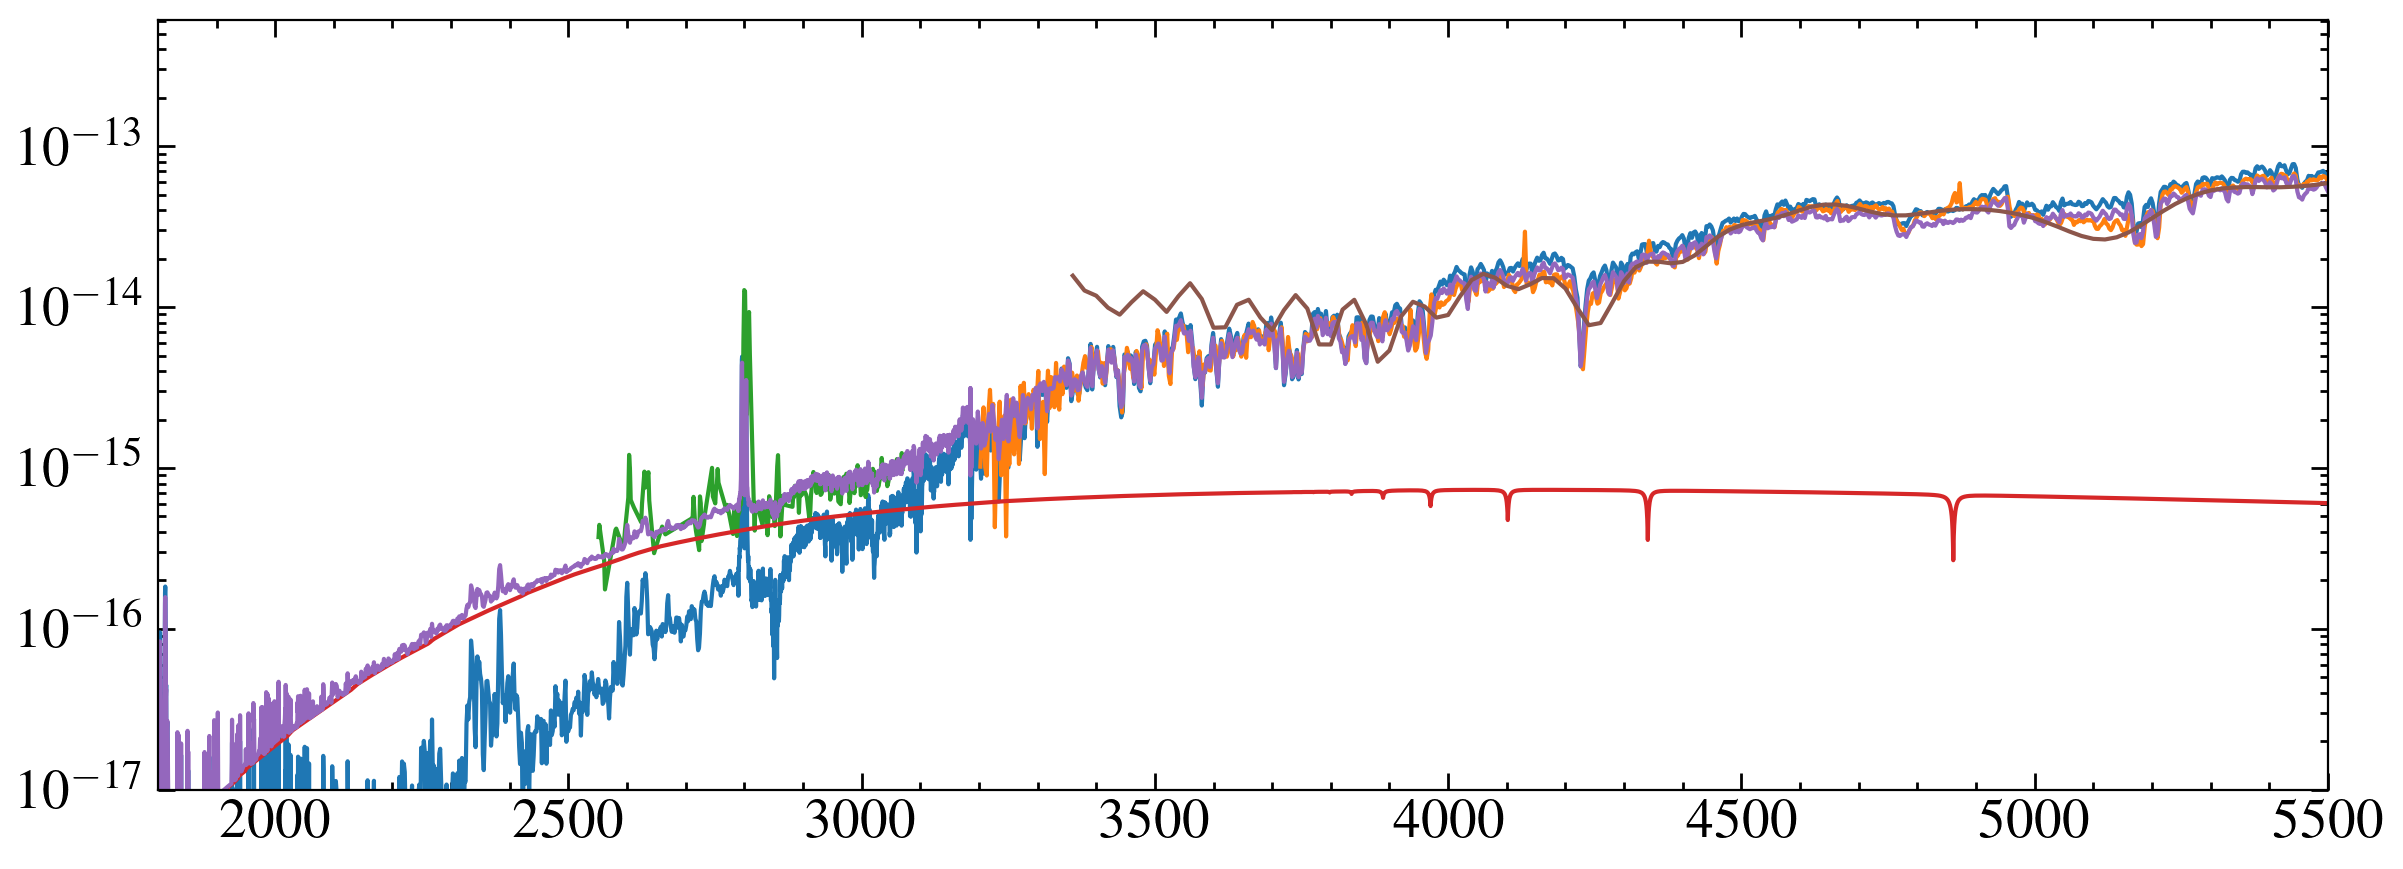

In [23]:
d832 = (1000/201.4073)
scale = (d832/dstar)**2
print(scale)

pmask = (dmw > 1200) & (dmw < 10000)

plt.plot(dmw[pmask], dmf[pmask]*scale*0.6)

plt.plot(sw[smask], sf[smask])
plt.plot(wn, fn)
# plt.plot(wdw, wdf)

wdw, wdf = np.loadtxt(mods[6], unpack=True)
tmod = os.path.split(mods[6])[1][2:7]
print(tmod)
wdmask =  (wdw > 1200) & (wdw < 10000) 
wdw, wdf = wdw[wdmask], wdf[wdmask]*wd_scale
plt.plot(wdw, wdf)

dmwi = dmw[pmask]
dmfi = dmf[pmask]

mfi = interp1d(wdw, wdf, fill_value='extrapolate')(dmwi)
mfi = mfi+(dmfi*scale*0.5)

plt.plot(dmwi, mfi)

plt.plot(gw, gf)
plt.yscale('log')
plt.ylim(1e-17)
# plt.xscale('log')
plt.xlim(1800, 5500)

06500


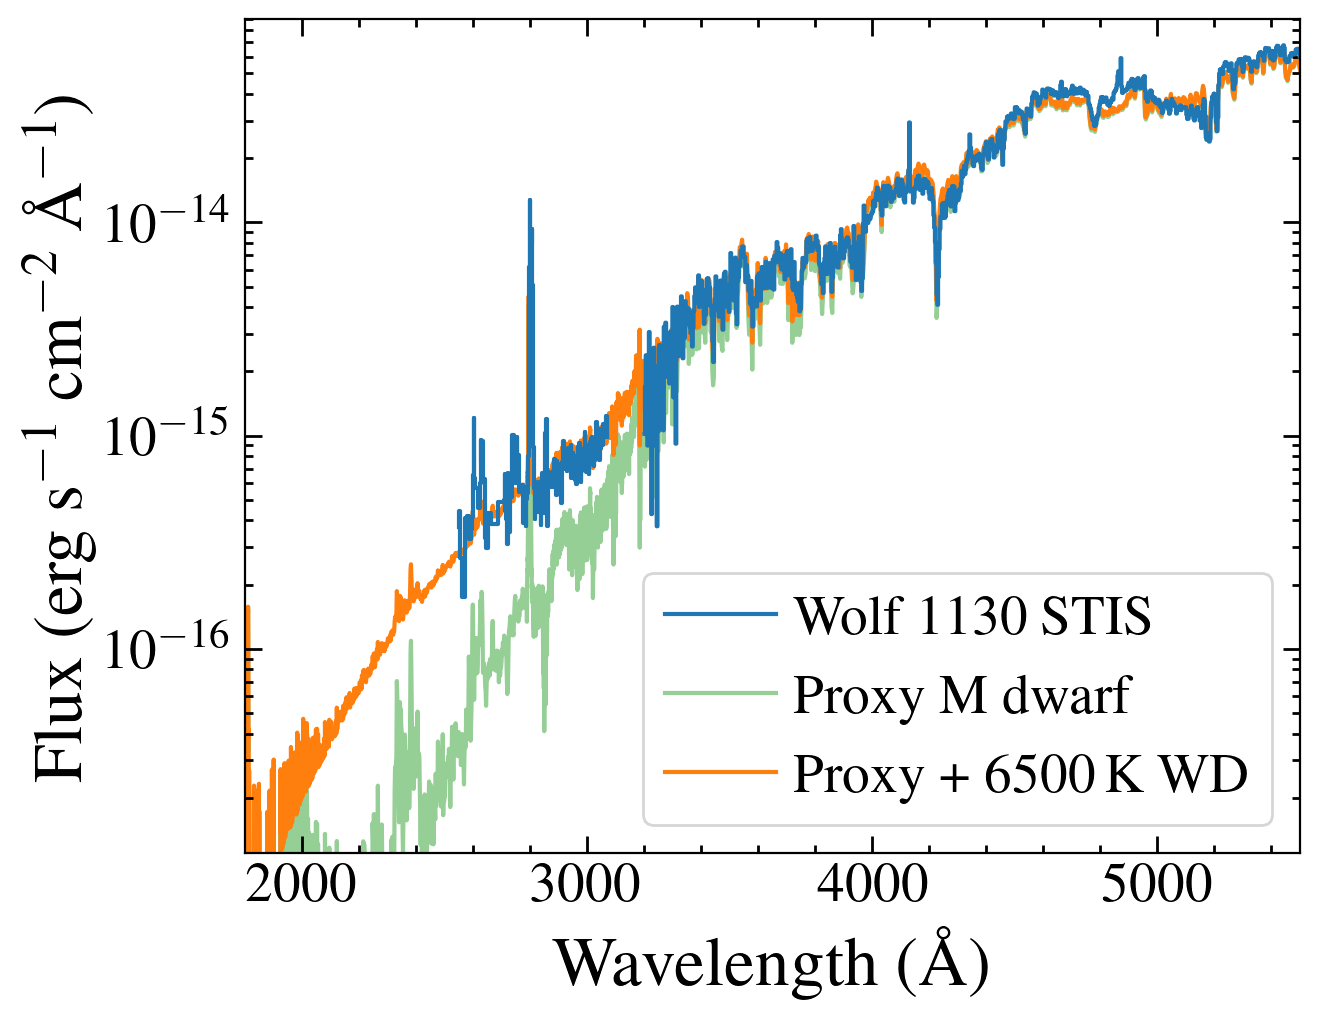

In [24]:
fig, ax = plt.subplots(figsize=(7,5.5))


ax.step(sw[smask], sf[smask], where='mid', c='C0', label = 'Wolf 1130 STIS')
ax.step(wn, fn, where='mid', c='C0')


ax.plot(dmw[pmask], dmf[pmask]*scale*0.5, alpha=0.5, c='C2', zorder=-10, label='Proxy M dwarf')


# plt.plot(wdw, wdf)

wdw, wdf = np.loadtxt(mods[6], unpack=True)
tmod = os.path.split(mods[6])[1][2:7]
print(tmod)
wdmask =  (wdw > 1200) & (wdw < 10000) 
wdw, wdf = wdw[wdmask], wdf[wdmask]*wd_scale
# plt.plot(wdw, wdf)

dmwi = dmw[pmask]
dmfi = dmf[pmask]

mfi = interp1d(wdw, wdf, fill_value='extrapolate')(dmwi)
mfi = mfi+(dmfi*scale*0.5)

ax.plot(dmwi, mfi, c='C1', zorder=-1, label='Proxy + 6500\,K WD')

# plt.plot(gw, gf)
ax.set_yscale('log')
ax.set_ylim(1.1e-17, 9e-14)
# plt.xscale('log')
ax.set_xlim(1800, 5500)
ax.legend(frameon=True)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)
ax.set_xlabel('Wavelength (\AA)', size=25)
fig.tight_layout()

fig.savefig('plots/wolf1130_spec.pdf')

In [25]:
mod = Table([dmwi[dmwi < 5500], mfi[dmwi < 5500]], names=['#WAVELENGTH', 'FLUX'])
mod.write('wolf1130_model.dat', format='ascii.basic', overwrite=True)

3 orbits https://etc.stsci.edu/etc/results/STIS.sp.1845405/